# Mass Phase Labeling of CHESS xrd data

This notebook uses the pyPhaseLabel wrapper that folds in the CrystalShift.jl and CrystalTree.jl packages for on the fly structural determination

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import json

import os
import glob
from scipy import interpolate
# This is the import stuff for the temperature profile and spatial conversion
from extraCode import *
from temp_profile import *
from temp_surface_Spring2022 import CO2_svp_conversion, CO2_inversion
from center_finder_asym import get_center_asym
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import gaussian_filter1d
def lorentz(x, height, x_0, width_x):
    return height / (1+((x-x_0)/width_x)**2)
parameters = {'axes.labelsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12,
              'legend.fontsize': 12,
              'legend.title_fontsize': 14,
              'axes.titlesize': 18}
plt.rcParams.update(parameters)
pfit = [ 9.28042059e-03, -4.04355686e-04,  7.25937223e-02, -5.44852557e-01, 3.55016440e+00]
left_width_fit  = [281.92169684,  -9.4047936 , -2.19357261]
right_width_fit = [211.76451937,  12.60267879, -2.53188879]
t_func = temp_surface(*pfit)
p_func = inverse_temp_surface(*pfit)

l_width = width_of_lorentzian(*left_width_fit)
r_width = width_of_lorentzian(*right_width_fit)
import matplotlib.gridspec as gridspec
def trigauss_bkgd(x,μ1,μ2,μ3,σ1,σ2,σ3,A1,A2,A3,m,b):
    """
    try to fit with a bigaussian with a linear shift plus 
    """
    return A1*np.exp(-(μ1-x)**2/σ1**2) + A2*np.exp(-(μ2-x)**2/σ2**2) + A3*np.exp(-(μ3-x)**2/σ3**2) + m*x + b

from scipy.optimize import curve_fit
from scipy.signal import find_peaks



#julia imports
from julia import Julia
from pathlib import Path

Julia(sysimage='/home/duncan/pyPhaseLabel/sys.so')
from julia import Main

Main.include('/home/duncan/BackgroundSubtraction.jl/src/BackgroundSubtraction.jl')

sys.path.insert(1,'/home/duncan/pyPhaseLabel/')
from cif_to_input_file import cif_to_input
from pyPhaseLabel import evaluate_obj, optimize_phase, create_phases, PhaseModel
from pyPhaseLabel import Lorentz, EQ, BackgroundModel, Wildcard, Gauss, FixedBackground
from julia.Main import Wildcard, Lazytree, search, get_probabilities, FixedPseudoVoigt

from julia.Main import BackgroundSubtraction
mcbl = BackgroundSubtraction.mcbl





### function to store fit parameters into structured H5

In [2]:
def store_opm(opm,key,conds,outfile='/path/to/stored.h5',fitstats=[],wce=True,wildcard=False,background=[]):
    """
    This will store the values of the optimized phases into an h5 file
    opm is the optimized phase object (required)
    key is the stored experimental condition
    conds are all the appropriate parameters for the stripe [tau,T,sv,P]
    fitstats contain the L2 norms and errors along the hessian
    wildcard is the wildcard phases (optional)
    background is the background model (optional)
    """
    
    #check if a file already exists
    try:
        plate = h5.File(outfile,'a')
    except:
        print('There is an issue loading the file')
    try:
        τ,T,sv,P = conds
    except:
        τ,T,sv,P,cations,fracs = conds
        
    clvl = f'{key}/T:_{round(T)}/phases'
    try:
        plate.create_group(clvl)
    except:
        pass
    plate[f'{key}/T:_{round(T)}'].attrs['T'] = T
    plate[f'{key}/T:_{round(T)}'].attrs['dwell'] = τ
    plate[f'{key}/T:_{round(T)}'].attrs['scanvelocity'] = sv
    plate[f'{key}/T:_{round(T)}'].attrs['Power'] = P
    plate[f'{key}/T:_{round(T)}'].attrs['bkgd_a'] = background
    
    try:
        plate[f'{key}/T:_{round(T)}'].attrs['cations'] = cations
        plate[f'{key}/T:_{round(T)}'].attrs['fracs'] = fracs
    except:
        pass
    
    for idx in range(len(opm.CPs)):
#         print(idx)
        pname = opm.CPs[idx].name

        #all the lps
        try:
            lplvl = clvl+f'/{str(idx)}/LPs/a'
            plate.create_dataset(name=lplvl, data=opm.CPs[idx].cl.a, dtype='float32')
        except:
            lplvl = clvl+f'/{str(idx)}/LPs/a'
            data = plate[lplvl]
            data = opm.CPs[idx].cl.a
            
        try:
            lplvl = clvl+f'/{str(idx)}/LPs/b'
            plate.create_dataset(name=lplvl, data=opm.CPs[idx].cl.b, dtype='float32')
        except:
            lplvl = clvl+f'/{str(idx)}/LPs/b'
            data = plate[lplvl]
            data = opm.CPs[idx].cl.b
            
        try:
            lplvl = clvl+f'/{str(idx)}/LPs/c'
            plate.create_dataset(name=lplvl, data=opm.CPs[idx].cl.c, dtype='float32')
        except:
            lplvl = clvl+f'/{str(idx)}/LPs/c'
            data = plate[lplvl]
            data = opm.CPs[idx].cl.c
            
        try:
            lplvl = clvl+f'/{str(idx)}/LPs/α'
            plate.create_dataset(name=lplvl, data=opm.CPs[idx].cl.α, dtype='float32')
        except:
            lplvl = clvl+f'/{str(idx)}/LPs/α'
            data = plate[lplvl]
            data = opm.CPs[idx].cl.α
            
        try:
            lplvl = clvl+f'/{str(idx)}/LPs/β'
            plate.create_dataset(name=lplvl, data=opm.CPs[idx].cl.β, dtype='float32')
        except:
            lplvl = clvl+f'/{str(idx)}/LPs/β'
            data = plate[lplvl]
            data = opm.CPs[idx].cl.β
            
        try:
            lplvl = clvl+f'/{str(idx)}/LPs/γ'
            plate.create_dataset(name=lplvl, data=opm.CPs[idx].cl.γ, dtype='float32')
        except:
            lplvl = clvl+f'/{str(idx)}/LPs/γ'
            data = plate[lplvl]
            data = opm.CPs[idx].cl.γ
        
        
        plate[clvl+f'/{str(idx)}'].attrs['norm_constant'] = opm.CPs[idx].norm_constant
        plate[clvl+f'/{str(idx)}'].attrs['activation'] = opm.CPs[idx].act
        plate[clvl+f'/{str(idx)}'].attrs['name'] = pname
        plate[clvl+f'/{str(idx)}'].attrs['σ'] = opm.CPs[idx].σ
        
        if len(fitstats)>0:
            L2norm = fitstats[0]
            nl2n = fitstats[1]
            errors = fitstats[2:] # needs to be flexible to the amount of peaks in the wildcard phase
            plate[f'{key}/T:_{round(T)}'].attrs['L2'] = L2norm
            plate[f'{key}/T:_{round(T)}'].attrs['normL2'] = nl2n
            
#             errors are formatted such that the lattice parameters are stored in a nx8 flattened array
#             for any crystalline phase. wildcard phases are accounted for by the remaining elements
#             (n x peak location, n x activation, n x height)
            for edx,lp in enumerate(['a','b','c','α','β','γ']):
                phase_err = errors[idx*8:(idx*8+6)]
                print(phase_err)
                val_LP = plate[clvl+f'/{str(idx)}/LPs/{lp}']
                real_phase_err = np.exp(np.log(val_LP) + phase_err) - val_LP
                print(real_phase_err)
                phase_err = real_phase_err
                try:
                    errlvl = clvl+f'/{str(idx)}/err_LPs/{lp}'
                    plate.create_dataset(name=errlvl,data=phase_err[edx],dtype='float32')
                except:
                    errlvl = clvl+f'/{str(idx)}/err_LPs/{lp}'
                    data = plate[errlvl] 
                    data = phase_err[edx]
            plate[clvl+f'/{str(idx)}'].attrs['δactivation'] = errors[idx*8+6]
            plate[clvl+f'/{str(idx)}'].attrs['δwidth'] = errors[idx*8+7]
            
        #amorphous signal modeled by trigaussian
        # 3x3 array with optimized locations,widths,activations
        if wce:
            try:
                wc_opt = opm.wildcard[0]
                plate.create_dataset(name=clvl+'/amorphous/params',data=np.array([wc_opt.peak_locs,wc_opt.σ,wc_opt.activations],dtype='float32'))
            except:
                wc_opt = opm.wildcard[0]
                data = plate[clvl+'/amorphous/params']
                data = np.array([[wc_opt.peak_locs],[wc_opt.σ],[wc_opt.activations]],dtype='float32')
    plate.close()

In [3]:
def Filt(prenorm, δprenorm, sigma):
#     check1 is to see if the δactivation is real and not NaN
#     check2 is to see if the σ parameter is effed up. if it is too low like < 0.5*dQ, then
#     the activation is very likely wrong
#     check 3 is a hard cutoff for activation likely close to the noise threshold of the raw data
    valid = np.full(len(prenorm),True)
    for i, pn in enumerate(prenorm):
        #check1
#         if (abs(δprenorm[i]/pn) > 0.005) or (np.isnan(δprenorm[i])):
        if np.isnan(δprenorm[i]):
            valid[i] = False
        #check2
        if sigma[i] < 0.005:
            valid[i] = False
        #check3
        if prenorm[i] < 0.0005:
            valid[i] = False
#     print(valid)
    return valid


## La-Mn-O
has the tree search method implemented.

This first block generates the appropriate sticks.csv

In [ ]:
#This block generates a set of inputs for optimization from the cif files
cifpaths = list(glob.glob('/home/duncan/Documents/CIFs/La-Mn-O/JustaFew/*.cif'))
print(cifpaths)
cif_to_input(cifpaths,'/home/duncan/Documents/Data/60882_LaMnOx_AL/KeyPhasesCIFs_',(0,66))

This block runs the body of the code

0 tau_250_T_809
Finding center


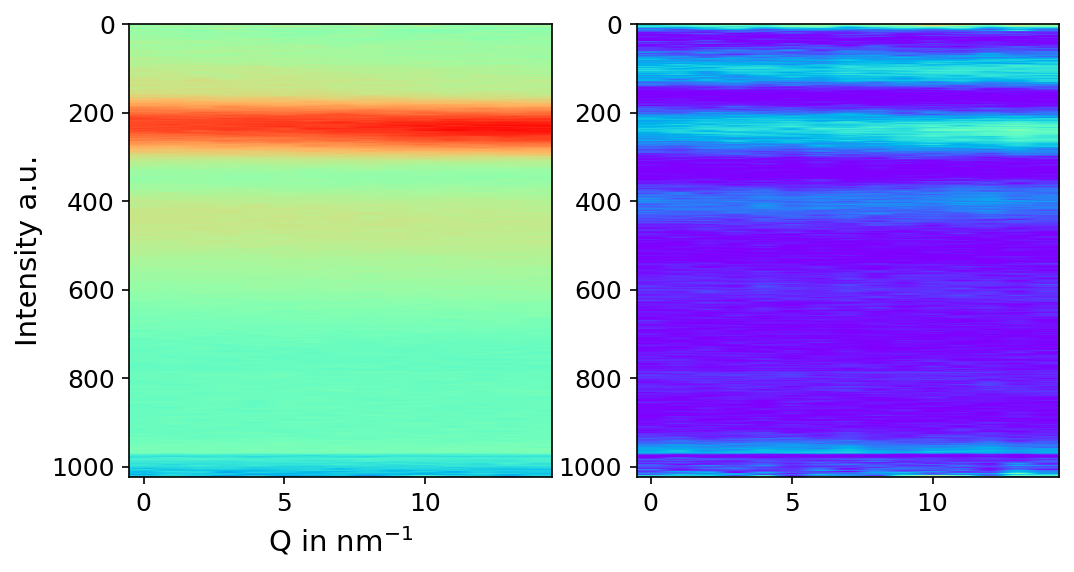

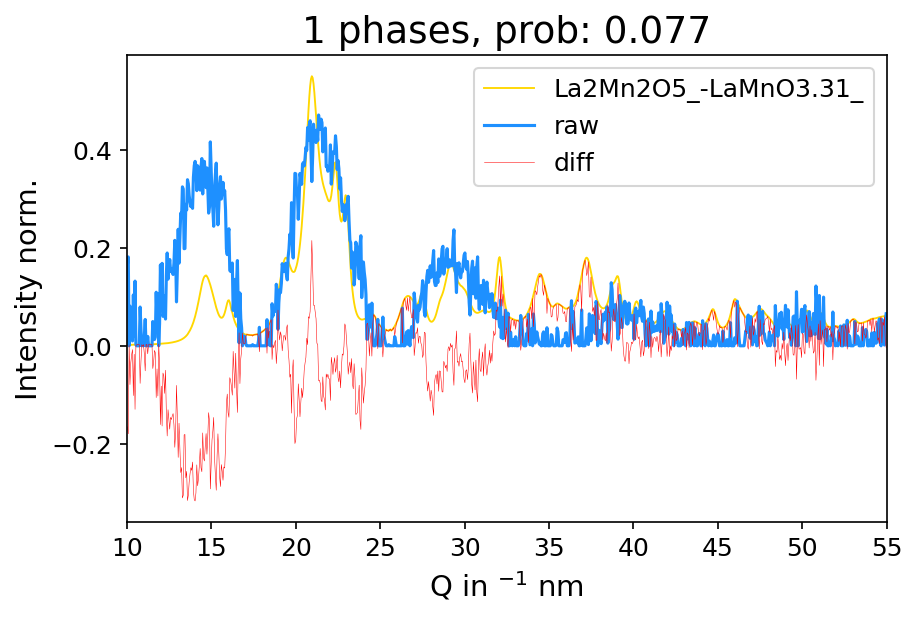

[5.97852097e-09 1.11946796e-08 7.79687290e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1.92545320e-06 2.01277359e-06 1.95589307e-06 1.82537060e-06
 1.82537060e-06 1.82537060e-06]
[5.97852097e-09 1.11946796e-08 7.79687290e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-6.74856659e-08 -3.36301742e-08 -5.56836479e-08 -1.06289273e-07
 -1.06289273e-07 -1.06289273e-07]
[5.97852097e-09 1.11946796e-08 7.79687290e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[4.38215041e-07 4.68311319e-07 4.48706598e-07 4.03720073e-07
 4.03720073e-07 4.03720073e-07]
[5.97852097e-09 1.11946796e-08 7.79687290e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 4.20654267e-09  1.24000656e-08  7.06280323e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[5.97852097e-09 1.11946796e-08 7.79687290e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 4.20654267e-09  1.24000656e-08  7.06280323e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[5.97852097e-09 1.11946796e-08 7.79687290e-09 0.0000

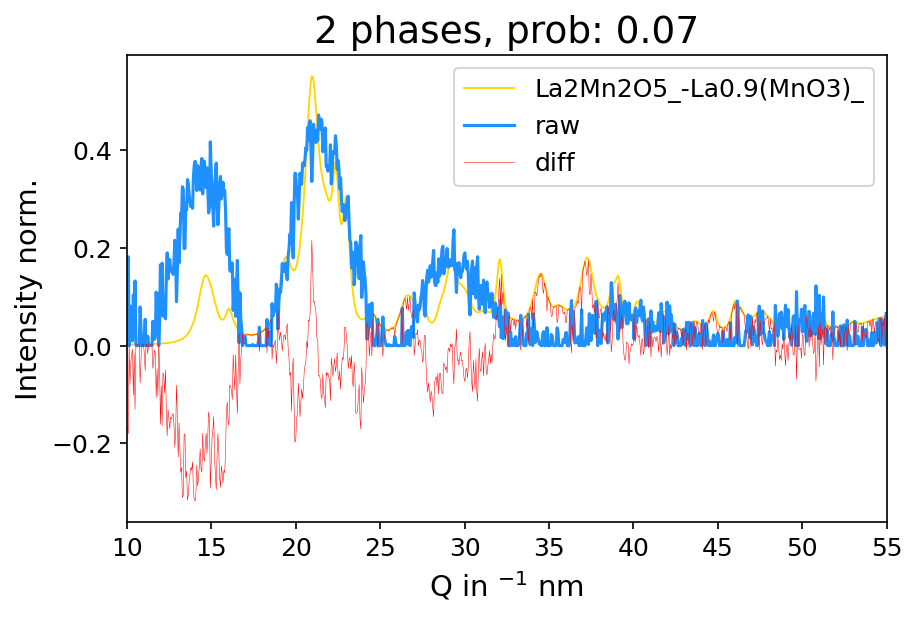

[5.61971912e-09 1.08942265e-08 7.08411008e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-4.74102269e-07 -3.85832546e-07 -4.49595447e-07 -5.68149154e-07
 -5.68149154e-07 -5.68149154e-07]
[5.61971912e-09 1.08942265e-08 7.08411008e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-3.73907440e-07 -3.39674904e-07 -3.64403269e-07 -4.10380465e-07
 -4.10380465e-07 -4.10380465e-07]
[5.61971912e-09 1.08942265e-08 7.08411008e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-1.77223346e-07 -1.46799276e-07 -1.68776541e-07 -2.09638644e-07
 -2.09638644e-07 -2.09638644e-07]
[5.61971912e-09 1.08942265e-08 7.08411008e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 3.64293795e-09  1.19281152e-08  5.94319793e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[5.61971912e-09 1.08942265e-08 7.08411008e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 3.64293795e-09  1.19281152e-08  5.94319793e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[5.61971912e-09 1.08942265e-08 7.0841100

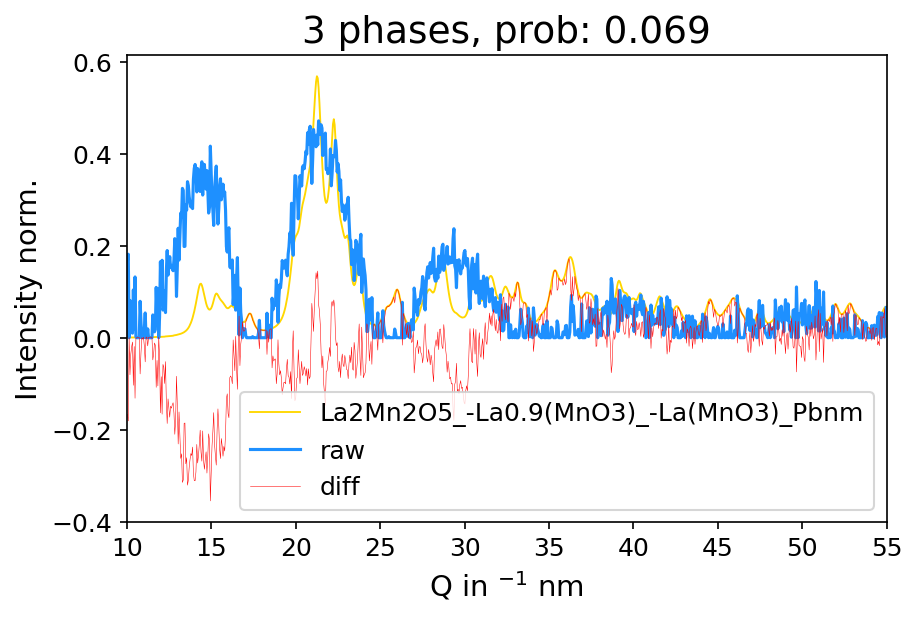

[5.78016717e-09 5.21163296e-09 3.16150249e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-1.61159616e-06 -1.62069724e-06 -1.65351569e-06 -1.70412495e-06
 -1.70412495e-06 -1.70412495e-06]
[5.78016717e-09 5.21163296e-09 3.16150249e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[2.33418698e-07 2.29834789e-07 2.16911245e-07 1.96981873e-07
 1.96981873e-07 1.96981873e-07]
[5.78016717e-09 5.21163296e-09 3.16150249e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-3.74675384e-08 -4.09166363e-08 -5.33540554e-08 -7.25337754e-08
 -7.25337754e-08 -7.25337754e-08]
[5.78016717e-09 5.21163296e-09 3.16150249e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 3.89496924e-09  3.00191760e-09 -2.18419727e-10 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[5.78016717e-09 5.21163296e-09 3.16150249e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 3.89496924e-09  3.00191760e-09 -2.18419727e-10 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[5.78016717e-09 5.21163296e-09 3.16150249e-09 

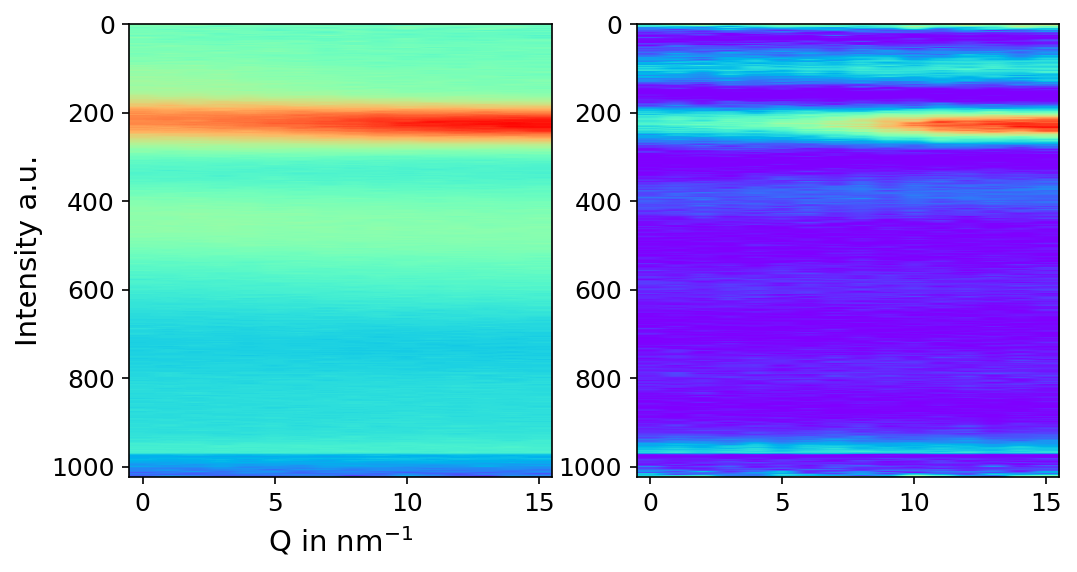

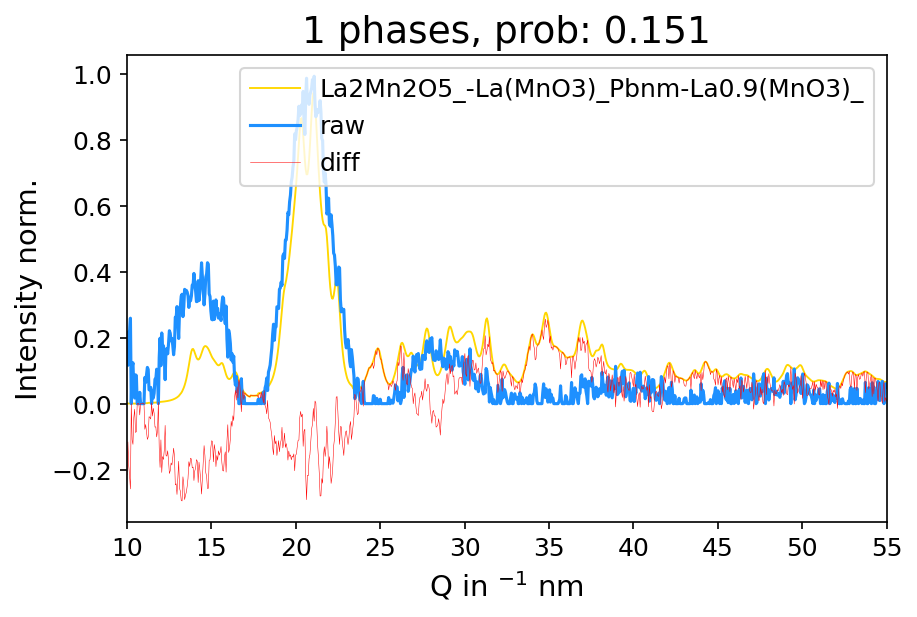

[7.74341812e-09 6.43034405e-09 5.51406925e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1.68664997e-06 1.66444206e-06 1.64894517e-06 1.55568614e-06
 1.55568614e-06 1.55568614e-06]
[7.74341812e-09 6.43034405e-09 5.51406925e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-2.09950597e-07 -2.18509259e-07 -2.24481568e-07 -2.60422458e-07
 -2.60422458e-07 -2.60422458e-07]
[7.74341812e-09 6.43034405e-09 5.51406925e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-1.11736607e-07 -1.20009579e-07 -1.25782534e-07 -1.60523715e-07
 -1.60523715e-07 -1.60523715e-07]
[7.74341812e-09 6.43034405e-09 5.51406925e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 6.97883662e-09  4.91626473e-09  3.47698359e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[7.74341812e-09 6.43034405e-09 5.51406925e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 6.97883662e-09  4.91626473e-09  3.47698359e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[7.74341812e-09 6.43034405e-09 5.51406925e-09 

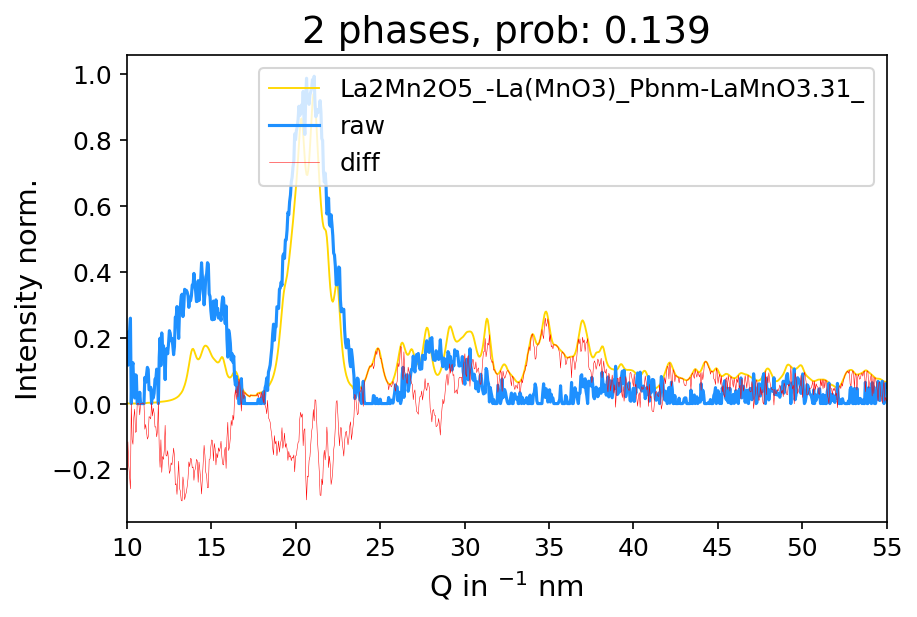

[7.42433349e-09 5.80165388e-09 5.17465639e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[6.88522231e-07 6.61096632e-07 6.50499484e-07 5.63040427e-07
 5.63040427e-07 5.63040427e-07]
[7.42433349e-09 5.80165388e-09 5.17465639e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-8.23249415e-08 -9.28984125e-08 -9.69839613e-08 -1.30702308e-07
 -1.30702308e-07 -1.30702308e-07]
[7.42433349e-09 5.80165388e-09 5.17465639e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-7.83160745e-08 -8.85393501e-08 -9.24895858e-08 -1.25091175e-07
 -1.25091175e-07 -1.25091175e-07]
[7.42433349e-09 5.80165388e-09 5.17465639e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 6.47761955e-09  3.92872046e-09  2.94383495e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[7.42433349e-09 5.80165388e-09 5.17465639e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 6.47761955e-09  3.92872046e-09  2.94383495e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[7.42433349e-09 5.80165388e-09 5.17465639e-09 

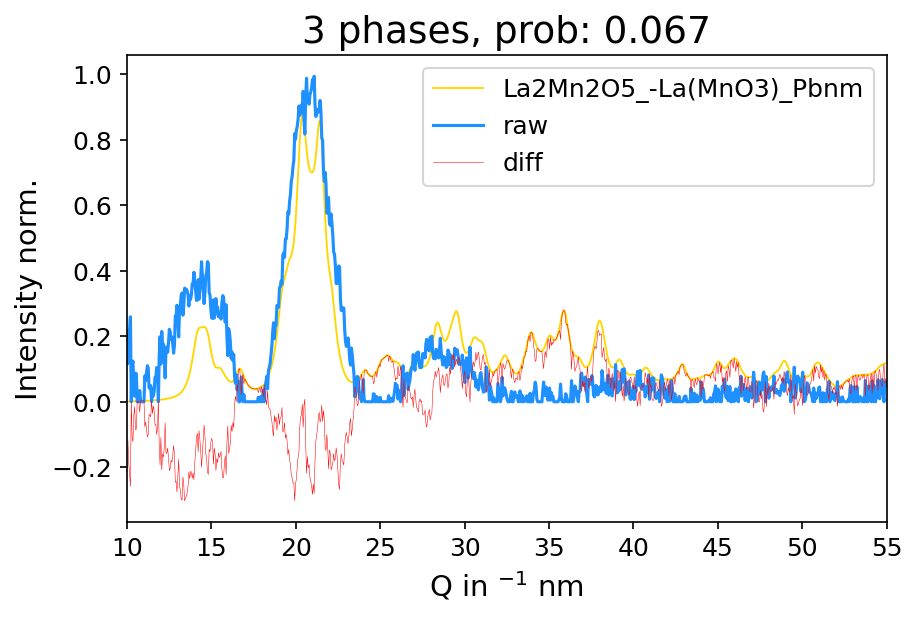

[8.69357444e-09 1.67996093e-08 6.06668927e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-2.64743019e-07 -1.25091919e-07 -3.09999098e-07 -4.14516268e-07
 -4.14516268e-07 -4.14516268e-07]
[8.69357444e-09 1.67996093e-08 6.06668927e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[3.76325001e-07 4.29495869e-07 3.59094165e-07 3.19300216e-07
 3.19300216e-07 3.19300216e-07]
[8.69357444e-09 1.67996093e-08 6.06668927e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 1.82975661e-08  6.70670488e-08  2.49306620e-09 -3.40068151e-08
 -3.40068151e-08 -3.40068151e-08]
[8.69357444e-09 1.67996093e-08 6.06668927e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 8.47133874e-09  2.12042690e-08  4.34503700e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[8.69357444e-09 1.67996093e-08 6.06668927e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 8.47133874e-09  2.12042690e-08  4.34503700e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[8.69357444e-09 1.67996093e-08 6.06668927e-09 

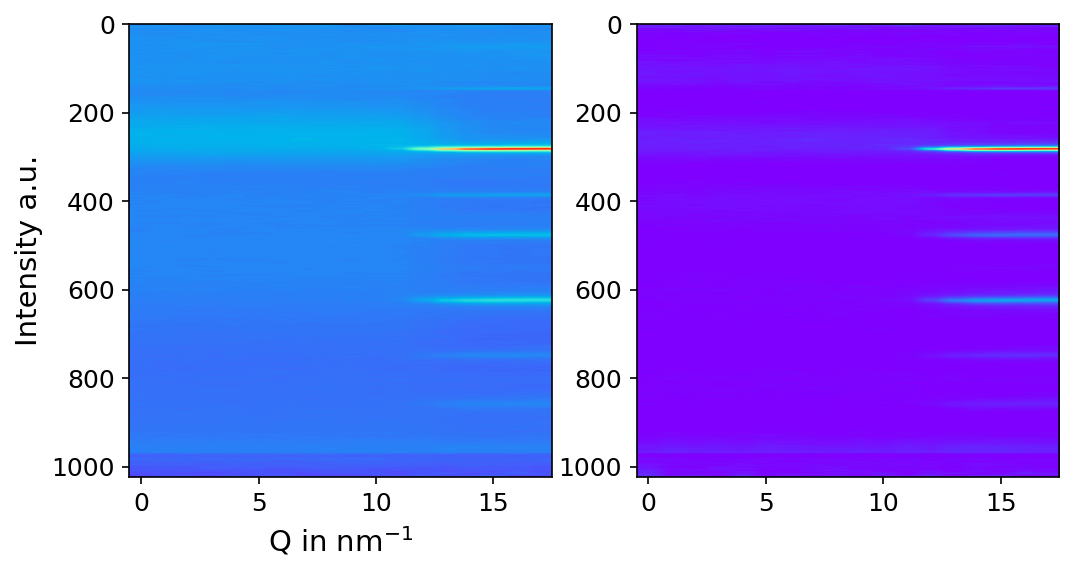

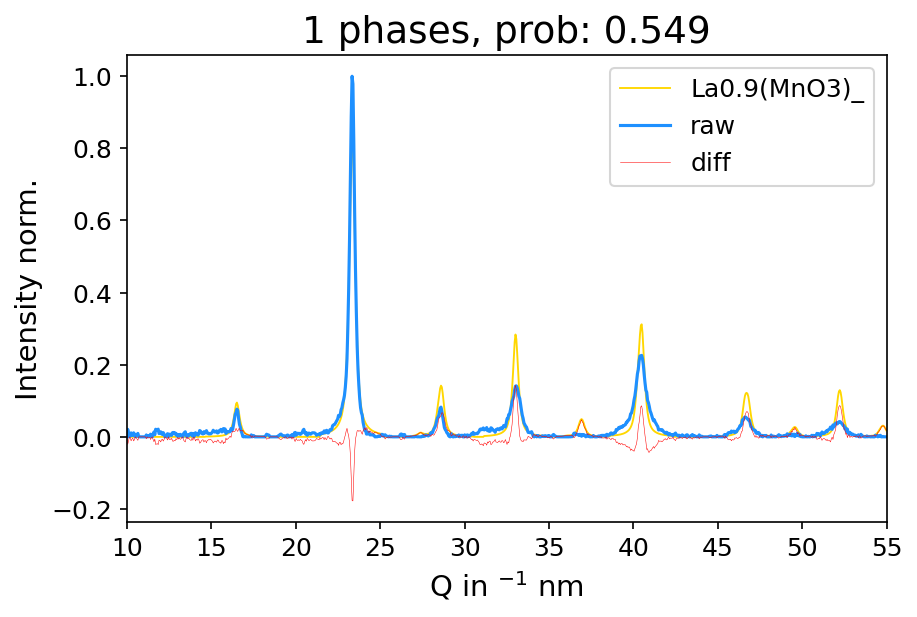

[9.41604103e-11 9.41604103e-11 9.41604103e-11 3.62955770e-10
 3.62955770e-10 3.62955770e-10]
[-1.96726463e-07 -1.96726463e-07 -1.96726463e-07 -1.95276987e-07
 -1.95276987e-07 -1.95276987e-07]
[9.41604103e-11 9.41604103e-11 9.41604103e-11 3.62955770e-10
 3.62955770e-10 3.62955770e-10]
[-1.96726463e-07 -1.96726463e-07 -1.96726463e-07 -1.95276987e-07
 -1.95276987e-07 -1.95276987e-07]
[9.41604103e-11 9.41604103e-11 9.41604103e-11 3.62955770e-10
 3.62955770e-10 3.62955770e-10]
[-1.96726463e-07 -1.96726463e-07 -1.96726463e-07 -1.95276987e-07
 -1.95276987e-07 -1.95276987e-07]
[9.41604103e-11 9.41604103e-11 9.41604103e-11 3.62955770e-10
 3.62955770e-10 3.62955770e-10]
[-1.83774529e-09 -1.83774529e-09 -1.83774529e-09 -1.55751589e-09
 -1.55751589e-09 -1.55751589e-09]
[9.41604103e-11 9.41604103e-11 9.41604103e-11 3.62955770e-10
 3.62955770e-10 3.62955770e-10]
[-1.83774529e-09 -1.83774529e-09 -1.83774529e-09 -1.55751589e-09
 -1.55751589e-09 -1.55751589e-09]
[9.41604103e-11 9.41604103e-11 9.4160410

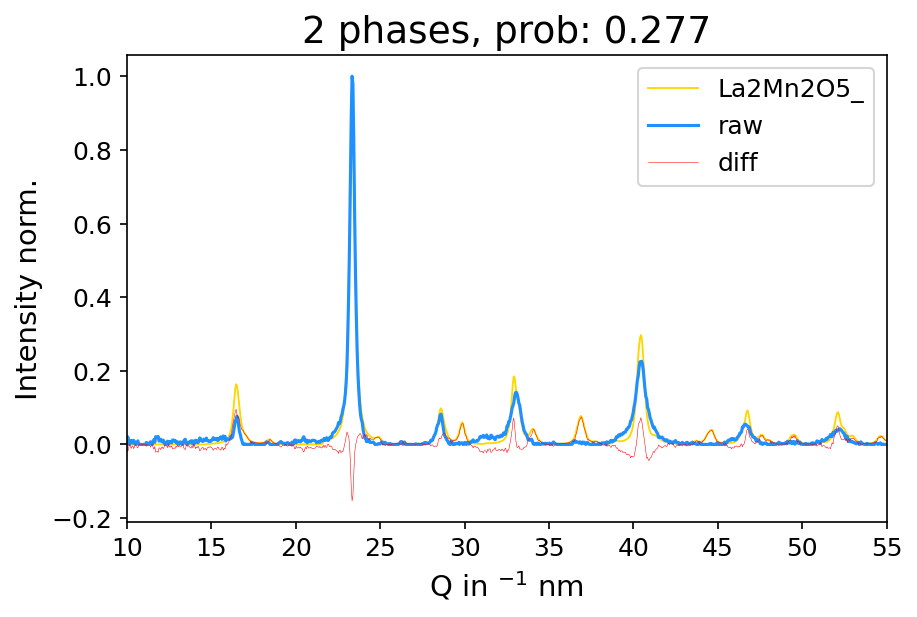

[3.96890993e-10 6.91424290e-10 4.91014547e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-5.10387984e-07 -5.05931107e-07 -5.08963710e-07 -5.16393737e-07
 -5.16393737e-07 -5.16393737e-07]
[3.96890993e-10 6.91424290e-10 4.91014547e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-2.56622718e-07 -2.55027840e-07 -2.56113045e-07 -2.58771855e-07
 -2.58771855e-07 -2.58771855e-07]
[3.96890993e-10 6.91424290e-10 4.91014547e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-2.52888658e-07 -2.51303412e-07 -2.52382064e-07 -2.55024818e-07
 -2.55024818e-07 -2.55024818e-07]
[3.96890993e-10 6.91424290e-10 4.91014547e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-4.56106153e-09 -4.09840961e-09 -4.41321246e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[3.96890993e-10 6.91424290e-10 4.91014547e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-4.56106153e-09 -4.09840961e-09 -4.41321246e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[3.96890993e-10 6.91424290e-10 4.9101454

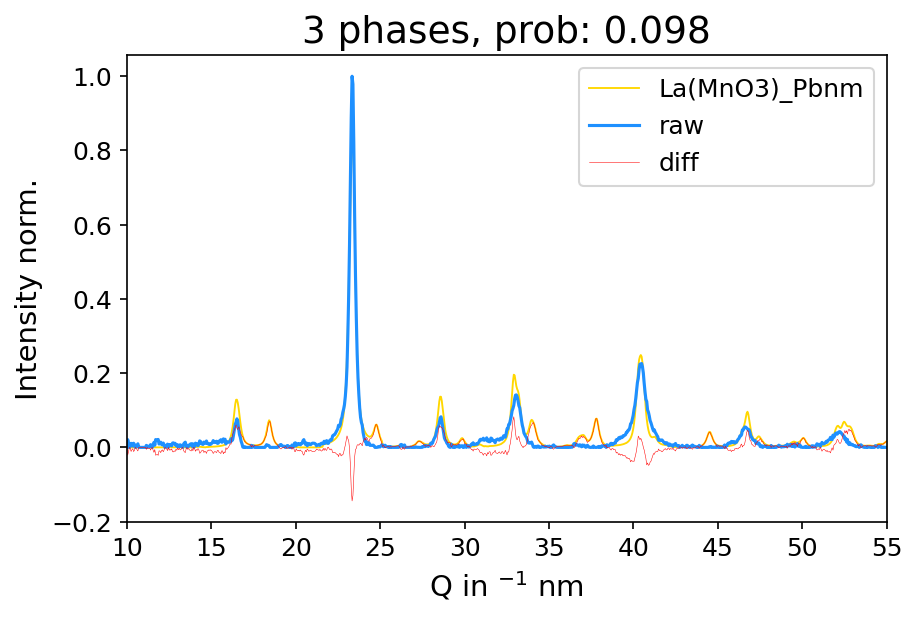

[4.78009899e-10 3.75855667e-10 2.30312733e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-9.85362556e-08 -9.90894025e-08 -9.98774903e-08 -1.01124591e-07
 -1.01124591e-07 -1.01124591e-07]
[4.78009899e-10 3.75855667e-10 2.30312733e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-2.27038166e-07 -2.27588034e-07 -2.28371452e-07 -2.29611160e-07
 -2.29611160e-07 -2.29611160e-07]
[4.78009899e-10 3.75855667e-10 2.30312733e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[6.16393226e-07 6.15620141e-07 6.14518695e-07 6.12775731e-07
 6.12775731e-07 6.12775731e-07]
[4.78009899e-10 3.75855667e-10 2.30312733e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-4.43364012e-09 -4.59410376e-09 -4.82272200e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[4.78009899e-10 3.75855667e-10 2.30312733e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-4.43364012e-09 -4.59410376e-09 -4.82272200e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[4.78009899e-10 3.75855667e-10 2.30312733e-10 

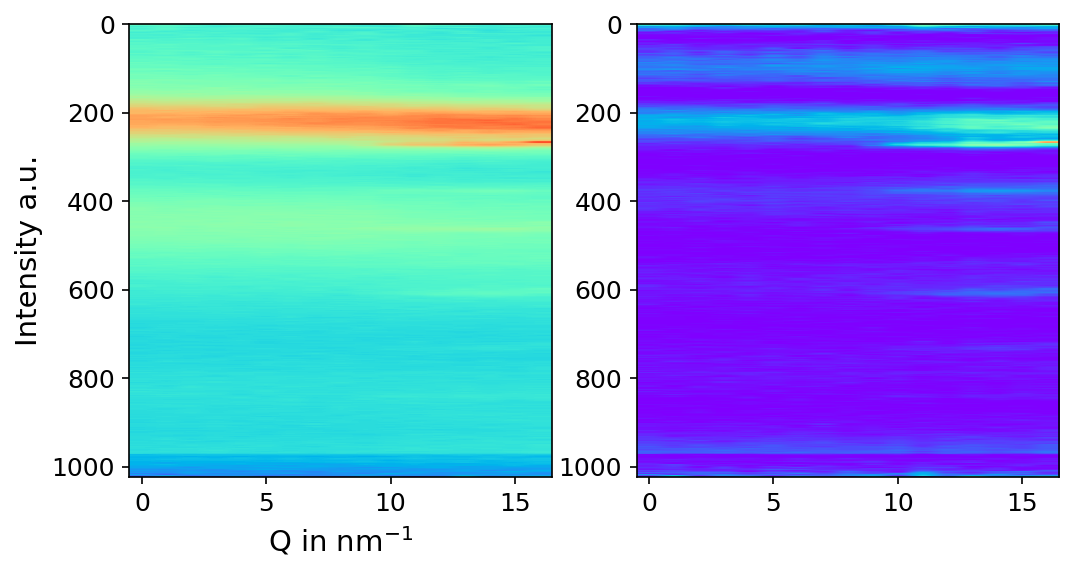

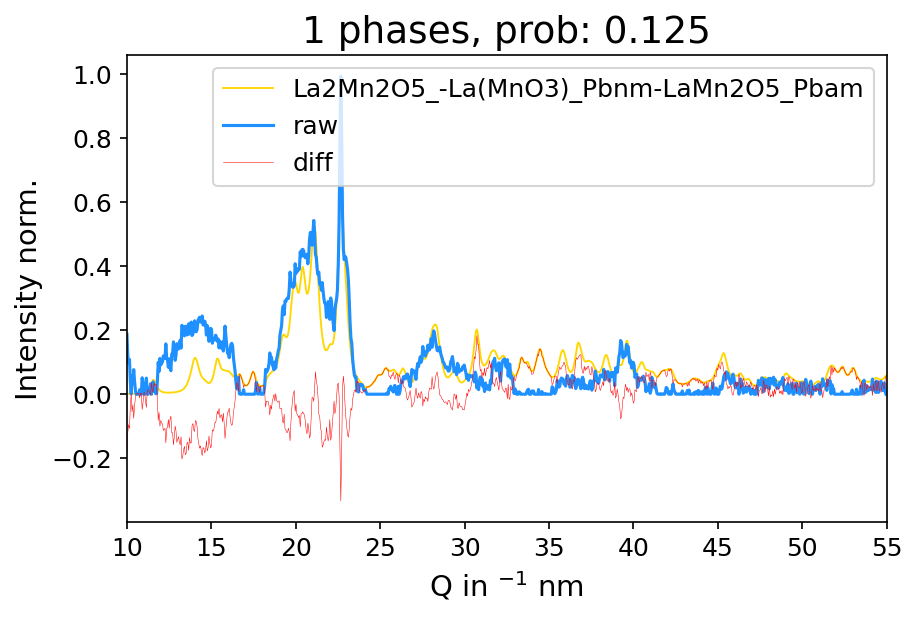

[4.84516002e-09 7.27941166e-09 7.33037956e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1.42351162e-06 1.46230003e-06 1.46311217e-06 1.34630678e-06
 1.34630678e-06 1.34630678e-06]
[4.84516002e-09 7.27941166e-09 7.33037956e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-3.36677100e-07 -3.20782865e-07 -3.20450075e-07 -3.68313150e-07
 -3.68313150e-07 -3.68313150e-07]
[4.84516002e-09 7.27941166e-09 7.33037956e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[2.47704761e-07 2.62671935e-07 2.62985315e-07 2.17913939e-07
 2.17913939e-07 2.17913939e-07]
[4.84516002e-09 7.27941166e-09 7.33037956e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 2.42626319e-09  6.24997698e-09  6.33003716e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[4.84516002e-09 7.27941166e-09 7.33037956e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 2.42626319e-09  6.24997698e-09  6.33003716e-09 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[4.84516002e-09 7.27941166e-09 7.33037956e-09 0.0000

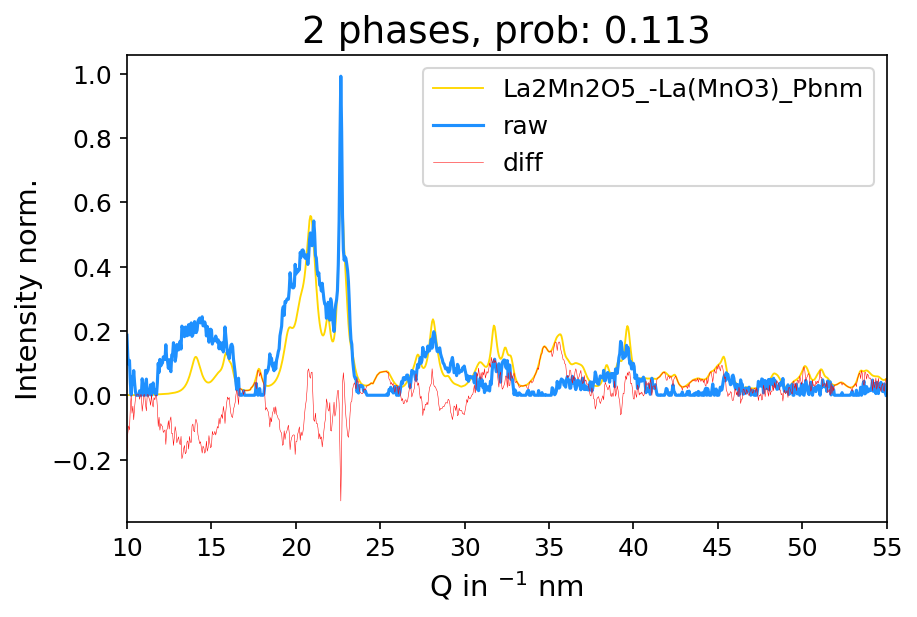

[3.06115105e-09 4.03967298e-09 3.00277212e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-1.37489046e-07 -1.21567286e-07 -1.38438935e-07 -1.87297729e-07
 -1.87297729e-07 -1.87297729e-07]
[3.06115105e-09 4.03967298e-09 3.00277212e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[2.58808094e-07 2.65089685e-07 2.58433331e-07 2.39157129e-07
 2.39157129e-07 2.39157129e-07]
[3.06115105e-09 4.03967298e-09 3.00277212e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[4.78936713e-08 5.39648832e-08 4.75314597e-08 2.89008426e-08
 2.89008426e-08 2.89008426e-08]
[3.06115105e-09 4.03967298e-09 3.00277212e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-3.76051412e-10  1.16100729e-09 -4.67752947e-10 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[3.06115105e-09 4.03967298e-09 3.00277212e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-3.76051412e-10  1.16100729e-09 -4.67752947e-10 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[3.06115105e-09 4.03967298e-09 3.00277212e-09 0.0000

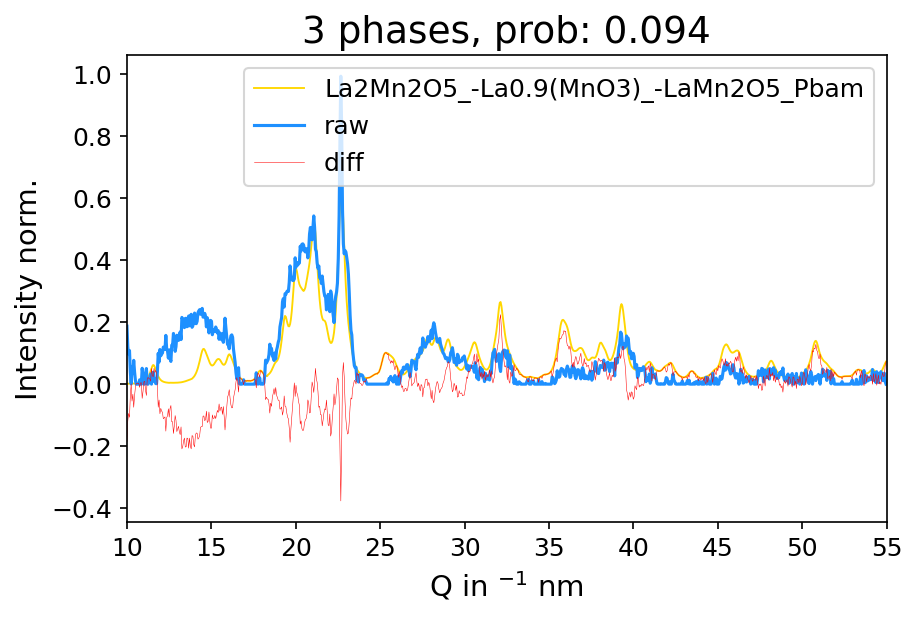

[5.69267309e-09 6.77769763e-09 9.85479888e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-4.11065461e-07 -3.93267921e-07 -3.42794557e-07 -5.04441765e-07
 -5.04441765e-07 -5.04441765e-07]
[5.69267309e-09 6.77769763e-09 9.85479888e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[2.85320697e-07 2.91904173e-07 3.10574737e-07 2.50779937e-07
 2.50779937e-07 2.50779937e-07]
[5.69267309e-09 6.77769763e-09 9.85479888e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-4.36094735e-07 -4.29391566e-07 -4.10381555e-07 -4.71263474e-07
 -4.71263474e-07 -4.71263474e-07]
[5.69267309e-09 6.77769763e-09 9.85479888e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 3.75753384e-09  5.46188628e-09  1.02953859e-08 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[5.69267309e-09 6.77769763e-09 9.85479888e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 3.75753384e-09  5.46188628e-09  1.02953859e-08 -5.18449639e-09
 -5.18449639e-09 -5.18449639e-09]
[5.69267309e-09 6.77769763e-09 9.85479888e-09 

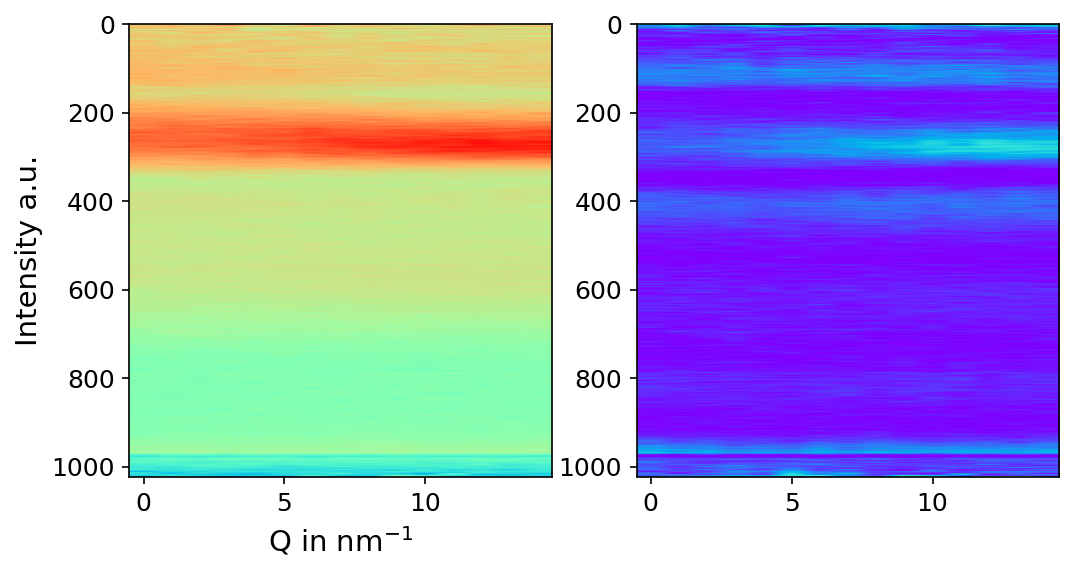

KeyboardInterrupt: 

In [31]:
### Loading the H5 file
# file="/home/duncan/Documents/Data/60882_LaMnOx_AL/38_60882_LaMnOx_AL_RUN_all_1d.h5"
file = "/home/duncan/Documents/Data/21F61_Bi-Ti-O/20b_21F61_Bi-Ti-O_all_1d.h5"
h5data = h5.File(file,'r')['exp']

###setting filtering criteria and the hyper parameters for the optimization code
ΔT = False
std_noise = .05
mean_θ = [1., 1., .2] 
std_θ = [.05, 1., .05] 
Trange = [400,1400]

### instantiating the phases in CrystalShift terminology and generating a tree to search through
LaMnOx_CIFs = create_phases(open('/home/duncan/Documents/Data/60882_LaMnOx_AL/KeyPhasesCIFs_sticks.csv','r').read(),0.1,FixedPseudoVoigt(0.8))
tree_cifs = open('/home/duncan/Documents/Data/60882_LaMnOx_AL/KeyPhasesCIFs_sticks.csv','r').read().split("#\n")
tree_cifs.remove("")

### the main loop iterating through each stripe in the dataset
for idx, key in enumerate(dwellsort(list(h5data))[44:60][::-1]):
    print(idx, key)
    
    ###build the heatmap from the 1D data
    tau = float(key.split('_')[1])
    Tmax = float(key.split('_')[3])
    
    ### set the temperature range in which to filter the data over
    if ΔT:
        Trange = [Tmax*(1-ΔT), Tmax]
    else:
        pass
    ### If there is compositional data associated with the stripe, it is called here
    try:
        cations = h5data[key].attrs['cations']
        fracs = h5data[key].attrs['fracs']
    except:
        cations = None
        fracs = None
        pass
    
    ### the scan velocity and the power are back calculated from the dwell time and Tmax
    sv, P = CO2_inversion(tau,Tmax)
    
    ### The x-ray heatmap is constructed
    xmap = []
    for i in sorted(list(h5data[key]),key=int):
        xmap.append(h5data[key][i]['integrated_1d'][1])
    xmap = np.array(xmap).T
    Q = np.array(h5data[key][i]['integrated_1d'][0])

    ### calculate the center of the stripe given the asymetry 
    ### and construct the appropriate lateral temperature profile
    _, center = get_center_asym(data=xmap.T)
    Γ = l_width(np.log10(sv),P)*1.04  #width is in pixels needs to be multiplied by 1.04 um/pixel to get distance
    x = np.linspace(0,xmap.shape[1]*10,xmap.shape[1]) - center*10
    L_T = lorentz(x,Tmax,0,Γ)
    
    
    ### left half of the stripe and within temperature bounds defined above
    xmap_l = xmap[:,[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])][0]]
    
    ### MCBL code on 2D data.
    #The inputs in order are
    # - the 2D data                       type:     (m x n) float64
    # - the x array                       type:     Array(1 x n) float64
    # - length scale of Y dim 1           type:     float
    # - length scale of Y dim 2           type:     Array(m x 1) float64
    # - nIterations                       type:     float
    Y = xmap_l
    X = Q.astype('float64')
    l_1 = 10.
    l_2 = 10*np.arange(xmap_l.shape[1],dtype='float64')
    nIter = 15.
    
    ### calculate the background
    bkgd = mcbl(Y, X, l_1, l_2, nIter)
    
    ### subtract the background
    ROI = (xmap_l - bkgd)
    
    ### left temperature profile extraction
    L_T = L_T[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])]
    
    
    
    
    ### build the lazy tree for a tree search
    tree = Lazytree(LaMnOx_CIFs, 3, x, 10, tree_cifs, False)
    
    ### normalize the spectra intensity at the center
    I_og = ROI[:,-1][(Q>10) & (Q<55)]
    I = I_og/np.max(ROI) + 1e-5

    #linearly scale the background out of the data (2022 data only)
    x = Q[(Q>10) & (Q<55)]
    
    ### MCBL check plot
    fig,ax = plt.subplots(1,2,dpi=150,figsize=(8,4))
    ax[0].imshow(xmap_l,cmap='rainbow',aspect='auto')
    ax[1].imshow(xmap_l-bkgd,cmap='rainbow',aspect='auto')
    ax[0].set(
        xlabel='Q in nm$^{-1}$',
        ylabel='Intensity a.u.',
    )
    plt.show()
    plt.close(fig)
    
    ### execute the tree search
    # - tree object
    # - X vector (Q)
    # - Y vector (intensity)
    # - number of layers (possible phase combinations)
    # - std. noise for the model
    # - mean_θ for optimizing
    # - std_θ for optimizing
    # - max interations for tree's initial optimization
    # - enforce regularization
    result = search(tree, x, I, 3, std_noise, mean_θ, std_θ, maxiter=200, regularization=True)
    
    ### concatenate the results into a list
    result_con = sum(result,[])
    
    ### calculate the probabilities (#MingsCoolProbabilisticModeling)
    probs = get_probabilities(result_con, x, I, std_noise, mean_θ, std_θ).tolist()
    
    ### Choose the top n candidates 
    top3 = sorted(zip(probs,result_con),key=lambda x: x[0],reverse=True)[:3]
    for ndx, (prob,n) in enumerate(top3):
        ###candidate model
        cand_model = evaluate_obj(n.phase_model, x)

        ###optimized model with uncertainties and store statistics
        opm, unc_est = optimize_phase(n.phase_model, x, I,std_θ=[0.2, 1.,.01], maxiter=1000, gives_uncertatinty=True)
        model = evaluate_obj(obj=opm,x=x)
        new_L2norm = np.sum(np.power(I-model,2)) #take this and divde by the average (diff/Avg)**2
        norm_L2norm = np.sum(np.power((I-model)/np.sqrt(I),2))
        fitstats=np.hstack((new_L2norm,norm_L2norm,unc_est))
        
        ### top 3 candidate models plotting
        fig,ax = plt.subplots(dpi=150,constrained_layout=True)
        labelname = '-'.join([n.phase_model.CPs[jdx].name for jdx in range(len(n.phase_model.CPs))])
        ax.plot(x, cand_model,c='gold',label=labelname,linewidth=0.9)
        ax.plot(x, I,c='dodgerblue',label='raw')
        ax.plot(x, cand_model-I,c='r',linewidth=0.25, label='diff')
        ax.set(
            title = f"{ndx+1} phases, prob: {np.round(prob,3)}",
            xlabel= 'Q in $^{-1}$ nm',
            ylabel= 'Intensity norm.',
            xlim = (10,55)
        )
        ax.legend()
        plt.show()
        plt.close()
        
        ### dump into an h5 file for later plotting and visualization
        store_opm(opm=opm,key=key,conds=[tau,Tmax,sv,P,cations,fracs],
                 outfile=f'/home/duncan/Documents/Data/60882_LaMnOx_AL/CrystalShiftPhaseLabels/60882_LaMnOx_AL_Rank_{ndx+1}_choice.h5',
                 fitstats=fitstats,wce=False,background=[])

# Bi2O3-TiO2

In [47]:
### Loading the H5 file
# file="/home/duncan/Documents/Data/60882_LaMnOx_AL/38_60882_LaMnOx_AL_RUN_all_1d.h5"
file = "/home/duncan/Documents/Data/21F61_Bi-Ti-O/20b_21F61_Bi-Ti-O_all_1d.h5"
h5data = h5.File(file,'r')['exp']

###setting filtering criteria and the hyper parameters for the optimization code
ΔT = False
std_noise = .05
mean_θ = [1., 1., .2] 
std_θ = [.05, 1., .05] 
Trange = [400,800]

### instantiating the phases in CrystalShift terminology and generating a tree to search through
stickpath = '/home/duncan/Documents/Data/21F61_Bi-Ti-O/KeyPhasesCIFs_sticks.csv'
BiTiOx_CIFs = create_phases(open(stickpath,'r').read(),0.1,FixedPseudoVoigt(0.8))
tree_cifs = open(stickpath,'r').read().split("#\n")
tree_cifs.remove("")

### the main loop iterating through each stripe in the dataset
for idx, key in enumerate(dwellsort(list(h5data))[-75:-80]):
    print(idx, key)
    
    ###build the heatmap from the 1D data
    tau = float(key.split('_')[1])
    Tmax = float(key.split('_')[3])
    
    ### set the temperature range in which to filter the data over
    if ΔT:
        Trange = [Tmax*(1-ΔT), Tmax]
    else:
        pass
    ### If there is compositional data associated with the stripe, it is called here
    try:
        cations = h5data[key].attrs['cations']
        fracs = h5data[key].attrs['fracs']
    except:
        cations = None
        fracs = None
        pass
    
    ### the scan velocity and the power are back calculated from the dwell time and Tmax
    sv, P = CO2_inversion(tau,Tmax)
    
    ### The x-ray heatmap is constructed
    xmap = []
    for i in sorted(list(h5data[key]),key=int):
        xmap.append(h5data[key][i]['integrated_1d'][1])
    xmap = np.array(xmap).T
    Q = np.array(h5data[key][i]['integrated_1d'][0])

    ### calculate the center of the stripe given the asymetry 
    ### and construct the appropriate lateral temperature profile
    _, center = get_center_asym(data=xmap.T)
    Γ = l_width(np.log10(sv),P)*1.04  #width is in pixels needs to be multiplied by 1.04 um/pixel to get distance
    x = np.linspace(0,xmap.shape[1]*10,xmap.shape[1]) - center*10
    L_T = lorentz(x,Tmax,0,Γ)
    
    
    ### left half of the stripe and within temperature bounds defined above
    xmap_l = xmap[:,[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])][0]]
    
    ### MCBL code on 2D data.
    #The inputs in order are
    # - the 2D data                       type:     (m x n) float64
    # - the x array                       type:     Array(1 x n) float64
    # - length scale of Y dim 1           type:     float
    # - length scale of Y dim 2           type:     Array(m x 1) float64
    # - nIterations                       type:     float
    Y = xmap_l
    X = Q.astype('float64')
    l_1 = 10.
    l_2 = 10*np.arange(xmap_l.shape[1],dtype='float64')
    nIter = 15.
    
    ### calculate the background
    bkgd = mcbl(Y, X, l_1, l_2, nIter)
    
    ### subtract the background
    ROI = (xmap_l - bkgd)
    
    ### left temperature profile extraction
    L_T = L_T[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])]
    
    
    
    
    ### build the lazy tree for a tree search
    tree = Lazytree(BiTiOx_CIFs, 3, x, 10, tree_cifs, False)
    
    ### normalize the spectra intensity at the center
    I_og = ROI[:,-1][(Q>10) & (Q<55)]
    I = I_og/np.max(ROI) + 1e-5

    #linearly scale the background out of the data (2022 data only)
    x = Q[(Q>10) & (Q<55)]
    
    ### MCBL check plot
    fig,ax = plt.subplots(1,2,dpi=150,figsize=(8,4))
    ax[0].imshow(xmap_l,cmap='rainbow',aspect='auto')
    ax[1].imshow(xmap_l-bkgd,cmap='rainbow',aspect='auto')
    ax[0].set(
        ylabel='Q in nm$^{-1}$',
        xlabel='positions in',
    )
    plt.show()
    plt.close(fig)
    
    ### execute the tree search
    # - tree object
    # - X vector (Q)
    # - Y vector (intensity)
    # - number of layers (possible phase combinations)
    # - std. noise for the model
    # - mean_θ for optimizing
    # - std_θ for optimizing
    # - max interations for tree's initial optimization
    # - enforce regularization
    result = search(tree, x, I, 3, std_noise, mean_θ, std_θ, maxiter=200, regularization=True)
    
    ### concatenate the results into a list
    result_con = sum(result,[])
    
    ### calculate the probabilities (#MingsCoolProbabilisticModeling)
    probs = get_probabilities(result_con, x, I, std_noise, mean_θ, std_θ).tolist()
    
    ### Choose the top n candidates 
    top3 = sorted(zip(probs,result_con),key=lambda x: x[0],reverse=True)[:3]
    for ndx, (prob,n) in enumerate(top3):
        ###candidate model
        cand_model = evaluate_obj(n.phase_model, x)

        ###optimized model with uncertainties and store statistics
        opm, unc_est = optimize_phase(n.phase_model, x, I,std_θ=[0.2, 1.,.01], maxiter=1000, gives_uncertatinty=True)
        model = evaluate_obj(obj=opm,x=x)
        new_L2norm = np.sum(np.power(I-model,2)) #take this and divde by the average (diff/Avg)**2
        norm_L2norm = np.sum(np.power((I-model)/np.sqrt(I),2))
        fitstats=np.hstack((new_L2norm,norm_L2norm,unc_est))
        
        ### top 3 candidate models plotting
        fig,ax = plt.subplots(dpi=150,constrained_layout=True)
        labelname = '-'.join([n.phase_model.CPs[jdx].name for jdx in range(len(n.phase_model.CPs))])
        ax.plot(x, cand_model,c='gold',label=labelname,linewidth=0.9)
        ax.plot(x, I,c='dodgerblue',label='raw')
        ax.plot(x, cand_model-I,c='r',linewidth=0.25, label='diff')
        ax.set(
            title = f"{ndx+1} phases, prob: {np.round(prob,3)}",
            ylabel= 'Q in $^{-1}$ nm',
            xlabel= 'Intensity norm.',
            xlim = (10,55)
        )
        ax.legend()
        plt.show()
        plt.close()
        
        ### dump into an h5 file for later plotting and visualization
#         store_opm(opm=opm,key=key,conds=[tau,Tmax,sv,P,cations,fracs],
#                  outfile=f'/home/duncan/Documents/Data/60882_LaMnOx_AL/CrystalShiftPhaseLabels/60882_LaMnOx_AL_Rank_{ndx+1}_choice.h5',
#                  fitstats=fitstats,wce=False,background=[])

# Mo-Mg-N

In [ ]:
cifpaths = list(glob.glob('/home/duncan/Documents/CIFs/Mo-Mg-N/JustaFew/*.cif'))
print(cifpaths)
cif_to_input(cifpaths,'/home/duncan/Documents/Data/Mo-Mg-N/KeyPhasesCIFs_',(0,66))

In [ ]:
MoMgN_CIFs = create_phases(open('/home/duncan/Documents/Data/Mo-Mg-N/KeyPhasesCIFs_sticks.csv','r').read(),0.1,Lorentz())
h5data = h5.File(file,'r')['exp']
lattice_params = []
totals = 0
for idx, key in enumerate(dwellsort(list(h5data))):
    print(idx, key)
    #build the heatmap from the 1D data
    tau = float(key.split('_')[1])
    Tmax = float(key.split('_')[3])
    try:
        cations = h5data[key].attrs['cations']
        fracs = h5data[key].attrs['fracs']
    except:
        pass
        
    print(cations,fracs)
    if ΔT:
        Trange = [Tmax*(1-ΔT), Tmax]
    else:
        pass
        
    print(Trange)
    
    sv, P = CO2_inversion(tau,Tmax)
    xmap = []
    for i in sorted(list(h5data[key]),key=int):
        xmap.append(h5data[key][i]['integrated_1d'][1])
    xmap = np.array(xmap).T
    Q = np.array(h5data[key][i]['integrated_1d'][0])
    
    # calculate the center given the asymetry and construct the appropriate lateral temperature profile
    _, center = get_center_asym(data=xmap.T)
    Γ = l_width(np.log10(sv),P)*1.04  #width is in pixels needs to be multiplied by 1.04 um/pixel to get distance
    x = np.linspace(0,xmap.shape[1]*10,xmap.shape[1]) - center*10
    L_T = lorentz(x,Tmax,0,Γ)
    
    ROI = xmap[:,[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])][0]]
    L_T = L_T[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])]
    
    
    for i in range(len(L_T)):
        totals += 1
#         I_og = ROI[:,i][(Q>10) & (Q<55)]
#         I = I_og/max(I_og)
        
#         x = Q[(Q>10) & (Q<55)]
#         bg1 = FixedBackground(fbkg(x),1.3,5.**4)
#         pm = PhaseModel(None, None,bg1)
#         pmb = optimize_phase(pm, x, I, maxiter=70)
#         #after scaling optimization, do a global shift. 
# #         I = I + (min(evaluate_obj(obj=pmb,x=x) - min(I)))
        
#         # then subtract the signal
#         I = I - evaluate_obj(obj=pmb,x=x)
#         Ishift = min(I)
#         if Ishift < 0:
#             I = I + abs(min(I))
            
#         pm = PhaseModel(MoMgN_CIFs, None, None)
#         opm, unc_est = optimize_phase(pm, x, I,std_θ=[0.1, 1.,.01], maxiter=1000, gives_uncertatinty=True) #[0.1, 1.,.01] for SnOx
#         model = evaluate_obj(obj=opm,x=x)
#         new_L2norm = np.sum(np.power(I-model,2)) #take this and divde by the average (diff/Avg)**2
#         norm_L2norm = np.sum(np.power((I-model)/np.sqrt(I),2))
#         fitstats=np.hstack((new_L2norm,norm_L2norm,unc_est))
#         store_opm(opm=opm,key=key,conds=[tau,L_T[i],sv,P,cations,fracs],
#                  outfile='/home/duncan/Documents/Data/Mo-Mg-N/4PhaseOpt.h5',
#                  fitstats=fitstats,wce=False,background=pmb.background.a)

#     bg1 = evaluate_obj(obj=pmb.background,x=x)

#     fig,ax = plt.subplots(2,1,dpi=150,figsize=(6,8))
#     ax[0].plot(x, I_og/max(I_og), c='dodgerblue',label='raw')
#     ax[0].plot(x, bg1, c='grey', linestyle='--', label='bkgd')
#     ax[0].set(
#         xlabel="Q in nm$^{-1}$",
#         ylabel="intensity (a.u.)",
#     )
# #     ax[1].plot(x, bg, c='grey', linestyle='--', label='bkgd')
#     for pdx in range(len(opm.CPs)):
#         ax[1].plot(x,evaluate_obj(opm.CPs[pdx],x=x),label=opm.CPs[pdx].name)
#     ax[1].plot(x,I, c='dodgerblue',label='raw')
#     ax[1].plot(x, model, c='gold', linewidth=0.75, label='model')
#     ax[1].plot(x, I-model,c='r',linewidth=0.75, label='diff')
#     ax[1].set(
#         xlabel="Q in nm$^{-1}$",
#         ylabel="intensity (a.u.)",
#         title=f"T: {np.round(L_T[i])} τ: {np.round(tau)} Mo: {np.round(fracs[0][0], 2)}"
#     )
#     ax[1].legend()
#     plt.tight_layout()
#     plt.show()
#     plt.close(fig)

# SnOx

In [ ]:
SnOx_CIFs = create_phases(open('/home/duncan/Documents/CIFs/Sn-O_1/5-Me_sticks.csv','r').read(),0.1,FixedPseudoVoigt(1.0))
h5data = h5.File(file,'r')['exp']
lattice_params = []
subt_shift = []
# for idx, key in enumerate(dwellsort(list(h5data))[25:27]):
#     print(idx, key)

key = 'tau_10000_T_1400'
#build the heatmap from the 1D data
tau = float(key.split('_')[1])
Tmax = float(key.split('_')[3])
if ΔT:
    Trange = [Tmax*(1-ΔT), Tmax]
else:
    pass

sv, P = CO2_inversion(tau,Tmax)
xmap = []
for i in sorted(list(h5data[key]),key=int):
    xmap.append(h5data[key][i]['integrated_1d'][1])
xmap = np.array(xmap).T
Q = np.array(h5data[key][i]['integrated_1d'][0])

# calculate the center given the asymetry and construct the appropriate lateral temperature profile
_, center = get_center_asym(data=xmap.T)
Γ = l_width(np.log10(sv),P)*1.04  #width is in pixels needs to be multiplied by 1.04 um/pixel to get distance
x = np.linspace(0,xmap.shape[1]*10,xmap.shape[1]) - center*10
L_T = lorentz(x,Tmax,0,Γ)

ROI = xmap[:,[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])][0]]
L_T = L_T[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])]

#     pmbs = np.zeros(ROI.shape)
#     for i, row in enumerate(ROI):
#         pmbs[i,:] = row - min(row)

#     bg = FixedBackground(fbkg(Q[(Q>10) & (Q<55)]),1.3,0.1)
#     bkg = evaluate_obj(x=Q[(Q>10) & (Q<55)],obj=bg)
#for each stripe, the amorphous signal is modeled with the first pattern of the xmap
am_og = savgol_filter(np.average(xmap[:,:15],axis=1)[(Q>10) & (Q<55)], window_length=19, polyorder=3)
am = am_og/max(am_og)
x = Q[(Q>10) & (Q<55)]
dQ = Q[1]-Q[0]
pdx,pstats = find_peaks(am,width=[75,600],height=(min(am),max(am)))
mdx = np.arange(len(am))[am==min(am)][0]
m = (am[mdx] - am[0])/dQ
b = am[0]

p0 =[x[pdx[0]], x[pdx[1]], 60, 
     pstats['widths'][0]*dQ, pstats['widths'][1]*dQ, pstats['widths'][1]*dQ,
     pstats['peak_heights'][0], pstats['peak_heights'][1], pstats['peak_heights'][1],
     m, b]
#     print(p0)
popt,pcov = curve_fit(trigauss_bkgd,x,am,p0=p0)
#popt returns μ,σ, and A for each of the peaks. these need to be converted to height and width
μ_locs = np.abs(popt[0:2])
σ_locs = np.abs(popt[3:5])
height = np.abs(popt[6:8]) #add a normalization 
#     reg_vect = [0.1, 0.1, 0.05, 0.05, 0.1, 0.1] #for 6% film
reg_vect = [0.05, 0.05, 0.05, 0.05, 0.01, 0.01] #for 10% film
#     reg_vect = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01]
for i in range(len(L_T)):
#         I = pmbs[:,i][(Q>10) & (Q<55)]
#         I = I/max(I)
    I_og = ROI[:,i][(Q>10) & (Q<55)]
    I = I_og/max(I_og)
#         print(height/(max(I_og)/max(am_og)))
    wc_amorph = Wildcard(μ_locs, height/(max(I_og)/max(am_og)), σ_locs,
               'amorphous', Gauss(),reg_vect)
    x = Q[(Q>10) & (Q<55)]
    bg1 = FixedBackground(fbkg(x),1.3,5.**4)
    pm = PhaseModel(None, None,bg1)
    pmb = optimize_phase(pm, x, I, maxiter=70)
    #after scaling optimization, do a global shift. 
#         I = I + (min(evaluate_obj(obj=pmb,x=x) - min(I)))

    # then subtract the signal
    I = I - evaluate_obj(obj=pmb,x=x)
    Ishift = min(I)
#         print(Ishift)
    subt_shift.append(Ishift)
    if Ishift < 0:
        I = I + abs(min(I))

    pm = PhaseModel(SnOx_CIFs, [wc_amorph],None)
    opm, unc_est = optimize_phase(pm, x, I,std_θ=[0.1, 1.,.01], maxiter=1000, gives_uncertatinty=True) #[0.1, 1.,.01] for SnOx
    model = evaluate_obj(obj=opm,x=x)
    new_L2norm = np.sum(np.power(I-model,2)) #take this and divde by the average (diff/Avg)**2
    norm_L2norm = np.sum(np.power((I-model)/np.sqrt(I),2))
    fitstats=np.hstack((new_L2norm,norm_L2norm,unc_est))
#         store_opm(opm=opm,key=key,conds=[tau,L_T[i],sv,P],
#                  outfile='/home/duncan/Documents/Data/22AJA-D02_SnOx_capped/left/NewXtalParams/opt_ortho_FixedBG_2.h5',
#                  fitstats=fitstats,wce=True,background=pmb.background.a)
#         store_opm(opm=opm,key=key,conds=[tau,L_T[i],sv,P],
#                  outfile='/home/duncan/Documents/Data/22AJA-K01_SnOx_capped/right/opt_all_FixedBG_2.h5',
#                  fitstats=fitstats,wce=True,background=pmb.background.a)
    bg1 = evaluate_obj(obj=pmb.background,x=x)
    amorph = evaluate_obj(obj=opm.wildcard,x=x)
    #     bg = evaluate_obj(obj=opm.background,x=x) 

    fig,ax = plt.subplots(1,1,dpi=150,figsize=(6,4))
    ax.plot(x, I_og/max(I_og), c='dodgerblue',label='raw')
    ax.plot(x, bg1, c='grey', linestyle='--', label='bkgd')
    ax.set(
        xlabel="Q in nm$^{-1}$",
        ylabel="intensity (a.u.)",
    )
    ax.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    #     ax[1].plot(x, bg, c='grey', linestyle='--', label='bkgd')
    fig,ax = plt.subplots(1,1,dpi=150,figsize=(6,4))
    for pdx in range(len(opm.CPs)):
        ax.plot(x,evaluate_obj(opm.CPs[pdx],x=x),label=opm.CPs[pdx].name)
    ax.plot(x, amorph, c='orchid', linewidth=1, label='amorph')
    ax.plot(x,I, c='dodgerblue',label='raw')
    ax.plot(x, model, c='gold', label='model')
    ax.plot(x, I-model,c='r',linewidth=0.75, label='diff')
    ax.set(
        xlabel="Q in nm$^{-1}$",
        ylabel="intensity (a.u.)",
        title=f"T: {np.round(L_T[i])} τ: {np.round(tau)}"
    )
    ax.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [ ]:
# file="/home/duncan/Documents/Data/22AJA-D02_SnOx_capped/right/21_22AJA-D02_SnOx_Al2O3_cap_right_all_1d.h5"
file="/home/duncan/Documents/Data/22AJA-K01_SnOx_capped/right/28_22AJA-K01_SnOx_Al2O3_cap_right_all_1d.h5"

In [ ]:
SnOx_CIFs = create_phases(open('/home/duncan/Documents/CIFs/Sn-O_1/5-Me_sticks.csv','r').read(),0.1,Lorentz())
h5data = h5.File(file,'r')['exp']
lattice_params = []
subt_shift = []
for idx, key in enumerate(dwellsort(list(h5data))):
    print(idx, key)

    #build the heatmap from the 1D data
    tau = float(key.split('_')[1])
    Tmax = float(key.split('_')[3])
    if ΔT:
        Trange = [Tmax*(1-ΔT), Tmax]
    else:
        pass

    sv, P = CO2_inversion(tau,Tmax)
    xmap = []
    for i in sorted(list(h5data[key]),key=int):
        xmap.append(h5data[key][i]['integrated_1d'][1])
    xmap = np.array(xmap).T
    Q = np.array(h5data[key][i]['integrated_1d'][0])

    # calculate the center given the asymetry and construct the appropriate lateral temperature profile
    _, center = get_center_asym(data=xmap.T)
    Γ = l_width(np.log10(sv),P)*1.04  #width is in pixels needs to be multiplied by 1.04 um/pixel to get distance
    x = np.linspace(0,xmap.shape[1]*10,xmap.shape[1]) - center*10
    L_T = lorentz(x,Tmax,0,Γ)

    ROI = xmap[:,[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])][0]]
    L_T = L_T[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])]

    #     pmbs = np.zeros(ROI.shape)
    #     for i, row in enumerate(ROI):
    #         pmbs[i,:] = row - min(row)

    #     bg = FixedBackground(fbkg(Q[(Q>10) & (Q<55)]),1.3,0.1)
    #     bkg = evaluate_obj(x=Q[(Q>10) & (Q<55)],obj=bg)
    #for each stripe, the amorphous signal is modeled with the first pattern of the xmap
    am_og = savgol_filter(np.average(xmap[:,:15],axis=1)[(Q>10) & (Q<55)], window_length=19, polyorder=3)
    am = am_og/max(am_og)
    x = Q[(Q>10) & (Q<55)]
    dQ = Q[1]-Q[0]
    pdx,pstats = find_peaks(am,width=[75,600],height=(min(am),max(am)))
    mdx = np.arange(len(am))[am==min(am)][0]
    m = (am[mdx] - am[0])/dQ
    b = am[0]

    p0 =[x[pdx[0]], x[pdx[1]], 60, 
         pstats['widths'][0]*dQ, pstats['widths'][1]*dQ, pstats['widths'][1]*dQ,
         pstats['peak_heights'][0], pstats['peak_heights'][1], pstats['peak_heights'][1],
         m, b]
    #     print(p0)
    popt,pcov = curve_fit(trigauss_bkgd,x,am,p0=p0)
    #popt returns μ,σ, and A for each of the peaks. these need to be converted to height and width
    μ_locs = np.abs(popt[0:2])
    σ_locs = np.abs(popt[3:5])
    height = np.abs(popt[6:8]) #add a normalization 
    #     reg_vect = [0.1, 0.1, 0.05, 0.05, 0.1, 0.1] #for 6% film
    reg_vect = [0.05, 0.05, 0.05, 0.05, 0.01, 0.01] #for 10% film
    #     reg_vect = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01]
    for i in range(len(L_T)):
    #         I = pmbs[:,i][(Q>10) & (Q<55)]
    #         I = I/max(I)
        I_og = ROI[:,i][(Q>10) & (Q<55)]
        I = I_og/max(I_og)
    #         print(height/(max(I_og)/max(am_og)))
        wc_amorph = Wildcard(μ_locs, height/(max(I_og)/max(am_og)), σ_locs,
                   'amorphous', Gauss(),reg_vect)
        x = Q[(Q>10) & (Q<55)]
        bg1 = FixedBackground(fbkg(x),1.3,5.**4)
        pm = PhaseModel(None, None,bg1)
        pmb = optimize_phase(pm, x, I, maxiter=70)
        #after scaling optimization, do a global shift. 
    #         I = I + (min(evaluate_obj(obj=pmb,x=x) - min(I)))

        # then subtract the signal
        I = I - evaluate_obj(obj=pmb,x=x)
        Ishift = min(I)
    #         print(Ishift)
        subt_shift.append(Ishift)
        if Ishift < 0:
            I = I + abs(min(I))

        pm = PhaseModel(SnOx_CIFs, [wc_amorph],None)
        opm, unc_est = optimize_phase(pm, x, I,std_θ=[0.1, 1.,.01], maxiter=1000, gives_uncertatinty=True) #[0.1, 1.,.01] for SnOx
        model = evaluate_obj(obj=opm,x=x)
        new_L2norm = np.sum(np.power(I-model,2)) #take this and divde by the average (diff/Avg)**2
        norm_L2norm = np.sum(np.power((I-model)/np.sqrt(I),2))
        fitstats=np.hstack((new_L2norm,norm_L2norm,unc_est))
    #         store_opm(opm=opm,key=key,conds=[tau,L_T[i],sv,P],
    #                  outfile='/home/duncan/Documents/Data/22AJA-D02_SnOx_capped/left/NewXtalParams/opt_ortho_FixedBG_2.h5',
    #                  fitstats=fitstats,wce=True,background=pmb.background.a)
        store_opm(opm=opm,key=key,conds=[tau,L_T[i],sv,P],
                 outfile='/home/duncan/Documents/Data/22AJA-K01_SnOx_capped/right/opt_all_FixedBG_2.h5',
                 fitstats=fitstats,wce=True,background=pmb.background.a)
    bg1 = evaluate_obj(obj=pmb.background,x=x)
    amorph = evaluate_obj(obj=opm.wildcard,x=x)
#     bg = evaluate_obj(obj=opm.background,x=x) 

    fig,ax = plt.subplots(1,1,dpi=150,figsize=(6,4))
    ax.plot(x, I_og/max(I_og), c='dodgerblue',label='raw')
    ax.plot(x, bg1, c='grey', linestyle='--', label='bkgd')
    ax.set(
        xlabel="Q in nm$^{-1}$",
        ylabel="intensity (a.u.)",
    )
    ax.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)
#     ax[1].plot(x, bg, c='grey', linestyle='--', label='bkgd')
    fig,ax = plt.subplots(1,1,dpi=150,figsize=(6,4))
    for pdx in range(len(opm.CPs)):
        ax.plot(x,evaluate_obj(opm.CPs[pdx],x=x),label=opm.CPs[pdx].name)
    ax.plot(x, amorph, c='orchid', linewidth=1, label='amorph')
    ax.plot(x,I, c='dodgerblue',label='raw')
    ax.plot(x, model, c='gold', label='model')
    ax.plot(x, I-model,c='r',linewidth=0.75, label='diff')
    ax.set(
        xlabel="Q in nm$^{-1}$",
        ylabel="intensity (a.u.)",
        title=f"T: {np.round(L_T[i])} τ: {np.round(tau)}"
    )
    ax.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [ ]:
## total integrated intensity
TII_norm = []
TII_og = []

for idx, key in enumerate(dwellsort(list(h5data))):
    print(idx, key)
    #build the heatmap from the 1D data
    tau = float(key.split('_')[1])
    Tmax = float(key.split('_')[3])
    
    if ΔT:
        Trange = [Tmax*(1-ΔT), Tmax]
    else:
        pass
        
    print(Trange)
    
    sv, P = CO2_inversion(tau,Tmax)
    xmap = []
    for i in sorted(list(h5data[key]),key=int):
        xmap.append(h5data[key][i]['integrated_1d'][1])
    xmap = np.array(xmap).T
    Q = np.array(h5data[key][i]['integrated_1d'][0])
    
    # calculate the center given the asymetry and construct the appropriate lateral temperature profile
    _, center = get_center_asym(data=xmap.T)
    Γ = l_width(np.log10(sv),P)*1.04  #width is in pixels needs to be multiplied by 1.04 um/pixel to get distance
    x = np.linspace(0,xmap.shape[1]*10,xmap.shape[1]) - center*10
    L_T = lorentz(x,Tmax,0,Γ)
    
    ROI = xmap[:,[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])][0]]
    L_T = L_T[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])]
    
    for i in range(len(L_T)):
        I_og = ROI[:,i][(Q>10) & (Q<55)]
        I = I_og/max(I_og)
        TII_og.append([tau,L_T[i],I_og])
        TII_norm.append([tau,L_T[i],I])

In [ ]:
raw_I = np.array([np.sum(row[2]) for row in TII_og])
norm_I = np.array([np.sum(row[2]) for row in TII_norm])
tau = np.array([row[0] for row in TII_og])
T = np.array([row[1] for row in TII_og])

fig,ax = plt.subplots(2,1,figsize=(6,8),dpi=300)
sp0 = ax[0].scatter(tau,T,c=raw_I,cmap='rainbow')
sp1 = ax[1].scatter(tau,T,c=norm_I,cmap='rainbow')
cb0 = plt.colorbar(sp0, ax=ax[0])
ax[0].set(
    xlabel='log$_{10}$(τ in μs)',
    ylabel='temperature in \u00B0C',
    xscale='symlog',
    title='integrated raw intensity'
)
cb1 = plt.colorbar(sp1, ax=ax[1])
ax[1].set(
    xlabel='log$_{10}$(τ in μs)',
    ylabel='temperature in \u00B0C',
    xscale='symlog',
    title='integrated normalized intensity'
)
fig.tight_layout()

In [ ]:
raw

# Try fitting for all xtal sytems

In [ ]:
h5data = h5.File(file,'r')['exp']
for xtalcif_fn in sorted(glob.glob('/home/duncan/Documents/CIFs/Sn-O_1/SnO2_all_xtalsystems/*.cif')):
    xtalsystem = os.path.basename(xtalcif_fn)[:-4]
    print(xtalsystem)
    !cp $xtalcif_fn /home/duncan/Documents/CIFs/Sn-O_1/5-Me/
    !python /home/duncan/pyPhaseLabel/cif_to_input_file.py
    !rm /home/duncan/Documents/CIFs/Sn-O_1/5-Me/*.cif
    SnOx_CIFs = create_phases(open('/home/duncan/Documents/CIFs/Sn-O_1/5-Me_sticks.csv','r').read(),0.1,Lorentz())

    
    
    lattice_params = []
    for idx, key in enumerate(dwellsort(list(h5data))[22:24]):
        print(idx, key)
        #build the heatmap from the 1D data
        tau = float(key.split('_')[1])
        Tmax = float(key.split('_')[3])

        if ΔT:
            Trange = [Tmax*(1-ΔT), Tmax]
        else:
            pass

#         print(Trange)

        sv, P = CO2_inversion(tau,Tmax)
        xmap = []
        for i in sorted(list(h5data[key]),key=int):
            xmap.append(h5data[key][i]['integrated_1d'][1])
        xmap = np.array(xmap).T
        Q = np.array(h5data[key][i]['integrated_1d'][0])

        # calculate the center given the asymetry and construct the appropriate lateral temperature profile
        _, center = get_center_asym(data=xmap.T)
        Γ = l_width(np.log10(sv),P)*1.04  #width is in pixels needs to be multiplied by 1.04 um/pixel to get distance
        x = np.linspace(0,xmap.shape[1]*10,xmap.shape[1]) - center*10
        L_T = lorentz(x,Tmax,0,Γ)

        ROI = xmap[:,[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])][0]]
        L_T = L_T[(x<=0) & (L_T>=Trange[0]) & (L_T<=Trange[1])]

        pmbs = np.zeros(ROI.shape)
        for i, row in enumerate(ROI):
            pmbs[i,:] = row - min(row)


        for i in range(len(L_T)):
            I = pmbs[:,i][(Q>10) & (Q<55)]
            I = I/max(I)
            x = Q[(Q>10) & (Q<55)]
            pm = PhaseModel(SnOx_CIFs, None,None)
#             opm, unc_est = optimize_phase(pm, x, I,std_θ=[1., 1.,.1], maxiter=2000, gives_uncertatinty=True) #[0.1,1.,.05] for SnOx
            opm = optimize_phase(pm, x, I,std_θ=[1., 1.,.1], maxiter=2000, gives_uncertatinty=False) #[0.1,1.,.05] for SnOx
            model = evaluate_obj(obj=opm,x=x)
            new_L2norm = np.sum(np.power(I-model,2))
#             fitstats=np.hstack((new_L2norm,unc_est))
#             store_opm(opm=opm,key=key,conds=[tau,L_T[i],sv,P],
#                      outfile='/home/duncan/Documents/Data/22AJA-D02_SnOx_capped/left/opt_ortho_xtalparams.h5',
#                      fitstats=fitstats,wce=False)
        LPs = [opm.CPs[0].cl.a,opm.CPs[0].cl.b,opm.CPs[0].cl.c,opm.CPs[0].cl.α,opm.CPs[0].cl.β,opm.CPs[0].cl.γ]
        txtstr = []
        for ldx,lp in enumerate(['a','b','c','α','β','γ']):
            if ldx < 3:
                txtstr.append(f'{lp}: {np.round(LPs[ldx],3)}')
            else:
                txtstr.append(f'{lp}: {np.round(np.rad2deg(LPs[ldx]),2)}')
        txtstr = '\n'.join(txtstr)
        print(txtstr)
        fig,ax = plt.subplots(dpi=150)
#         ax.plot(x, bg, c='grey', linestyle='--', label='bkgd')
        for pdx in range(len(opm.CPs)):
            ax.plot(x,evaluate_obj(opm.CPs[pdx],x=x),label=opm.CPs[pdx].name)
        ax.plot(x,I, c='dodgerblue',label='raw')
        ax.plot(x, model, c='gold', label='model')
        ax.plot(x, I-model,c='r',linewidth=0.75, label='diff')
        ax.set(
            xlabel="Q in nm$^{-1}$",
            ylabel="intensity (a.u.)",
            title=f"{xtalsystem.split('_')[-1]} T: {int(np.round(L_T[i]))} τ: {int(np.round(tau))}"
        )
        ax.text(0.05, 0.95, txtstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
        ax.legend()
        plt.show()
        plt.close(fig)